In [1]:
import os
import numpy as np
import logging
from train_test import train, test
import warnings
import json
from arg_parser import init_parser
from setproctitle import setproctitle as ptitle
from enviroment import ARC_Env
import gymnasium as gym
from action_space import ARCActionSpace
import torch

In [2]:
import argparse

def init_parser(alg):

    if alg == 'WOLP_DDPG':
        parser = argparse.ArgumentParser(description='WOLP_DDPG')
        parser.add_argument('--env', default='ARC', metavar='ENV', help='environment to train on')
        parser.add_argument('--gamma', type=float, default=0.99, metavar='G', help='discount factor for rewards (default: 0.99)')
        parser.add_argument('--max-episode-length', type=int, default=50, metavar='M', help='maximum length of an episode (default: 1440)') #NOTE: changed from 1440 to 5
        parser.add_argument('--load', default=False, metavar='L', help='load a trained model')
        parser.add_argument('--load-model-dir', default='ARC-run975', metavar='LMD', help='folder to load trained models from')
        parser.add_argument('--gpu-ids', type=int, default=[1], nargs='+', help='GPUs to use [-1 CPU only]')
        parser.add_argument('--gpu-nums', type=int, default=8, help='#GPUs to use (default: 1)')
        parser.add_argument('--max-episode', type=int, default=20000, help='maximum #episode.')
        parser.add_argument('--test-episode', type=int, default=20, help='maximum testing #episode.')
        parser.add_argument('--max-actions', default=1e8, type=int, help='# max actions')
        parser.add_argument('--id', default='0', type=str, help='experiment id')
        parser.add_argument('--mode', default='train', type=str, help='support option: train/test')
        parser.add_argument('--hidden1', default=256, type=int, help='hidden num of first fully connect layer')
        parser.add_argument('--hidden2', default=128, type=int, help='hidden num of second fully connect layer')
        parser.add_argument('--c-lr', default=1e-3, type=float, help='critic net learning rate')
        parser.add_argument('--p-lr', default=1e-3, type=float, help='policy net learning rate (only for DDPG)')
        parser.add_argument('--warmup', default=500, type=int, help='time without training but only filling the replay memory')
        parser.add_argument('--bsize', default=32, type=int, help='minibatch size')
        parser.add_argument('--rmsize', default=100000, type=int, help='memory size')
        parser.add_argument('--window_length', default=1, type=int, help='')
        parser.add_argument('--tau-update', default=0.0005, type=float, help='moving average for target network')
        parser.add_argument('--ou_theta', default=0.5, type=float, help='noise theta')
        parser.add_argument('--ou_sigma', default=0.2, type=float, help='noise sigma')
        parser.add_argument('--ou_mu', default=0.0, type=float, help='noise mu')
        parser.add_argument('--init_w', default=0.003, type=float, help='')
        parser.add_argument('--epsilon', default=100000, type=int, help='Linear decay of exploration policy')
        parser.add_argument('--seed', default=-1, type=int, help='')
        parser.add_argument('--weight-decay', default=0.00001, type=float, help='weight decay for L2 Regularization loss')
        parser.add_argument('--save_per_epochs', default=25, type=int, help='save model every X epochs')
        parser.add_argument('--actor_critic_type', default='cnn', type=str, help='type of model to use (lpn, cnn, mlp)')
        parser.add_argument('--k_neighbors', default=25, type=int, help='number of neighbors to consider')
        parser.add_argument('--load_action_embedding', default=True, type=bool, help='load action embedding or not')
        parser.add_argument('--latent_dim', default=48, type=int, help='latent dimension for encoder')
        parser.add_argument('--chunk_size', default=10, type=int, help='chunk size for training encoder')
        parser.add_argument('--epsilon_start', default=1.0, type=float, help='starting epsilon value, useful for resuming training')
        parser.add_argument('--num_experiments_filter', default=20, type=int, help='number of problems on which to calculate the change percentage when filtering actions')
        parser.add_argument('--filter_threshold', default=0.3, type=float, help='percentage of random problems an action must change not to be filtered')
        parser.add_argument('--num_experiments_similarity', default=500, type=int, help='number of problems on which to calculate approximate similarity matrix between actions')
        parser.add_argument('--max_embedding', default=10., type=float, help='Maximum value for numbers in the embedding matrix')
        parser.add_argument('--min_embedding', default=-10., type=float, help='Minimum value for numbers in the embedding matrix')
        return parser
    else:
        raise RuntimeError('undefined algorithm {}'.format(alg))

In [3]:
import sys
sys.argv = ['notebook']  # Replace with a dummy argument list

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print('Using device: {}'.format(device))


ptitle('WOLP_DDPG')
warnings.filterwarnings('ignore')
parser = init_parser('WOLP_DDPG')
args = parser.parse_args()

os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_ids)[1:-1]

Using device: mps


In [4]:
from utils.util import get_output_folder, setup_logger
from wolp_agent import WolpertingerAgent
import os

# Change the current working directory to the parent folder
os.chdir('..')

args.save_model_dir = get_output_folder('../output', args.env)

challenge_dictionary = json.load(open('data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
action_space_args = {
        'num_experiments_filter': args.num_experiments_filter, 
        'filter_threshold': args.filter_threshold, 
        'num_experiments_similarity': args.num_experiments_similarity,
        'load': args.load_action_embedding
    }

action_space = ARCActionSpace(args)
env = ARC_Env(challenge_dictionary, action_space)
continuous = None

# discrete action for 1 dimension
# TODO: change the nb_states to the shape of the grid
nb_states = 1805  # 60 x 30 grid ravels to 1800 + 4 for the dimensions of the grid + 1 for cls embedding
nb_actions = 20  # the dimension of actions, usually it is 1. Depend on the environment.
continuous = False

if args.seed > 0:
    np.random.seed(args.seed)
    env.seed(args.seed)

agent_args = {
    'nb_states': nb_states,
    'nb_actions': nb_actions,
    'args': args,
    'k': args.k_neighbors,
    'action_space': action_space
}

agent = WolpertingerAgent(**agent_args)

if args.load:
    agent.load_weights(args.load_model_dir)

if args.gpu_ids[0] >= 0 and args.gpu_nums > 0 and torch.cuda.is_available():
    agent.cuda_convert()

# set logger, log args here
log = {}
if args.mode == 'train':
    setup_logger('RS_log', r'{}/RS_train_log'.format(args.save_model_dir))
elif args.mode == 'test':
    setup_logger('RS_log', r'{}/RS_test_log'.format(args.save_model_dir))
else:
    raise RuntimeError('undefined mode {}'.format(args.mode))

log['RS_log'] = logging.getLogger('RS_log')
d_args = vars(args)
d_args['max_actions'] = args.max_actions

for key in agent_args.keys():
    if key == 'args':
        continue
    d_args[key] = agent_args[key]
for k in d_args.keys():
    log['RS_log'].info('{0}: {1}'.format(k, d_args[k]))

if args.mode == 'train':
    print('Training')

    train_args = {
        'continuous': continuous,
        'env': env,
        'agent': agent,
        'max_episode': args.max_episode,
        'max_actions': args.max_actions,
        'warmup': args.warmup,
        'save_model_dir': args.save_model_dir,
        'max_episode_length': args.max_episode_length,
        'logger': log['RS_log'],
        'save_per_epochs': args.save_per_epochs
    }

    train(**train_args)

elif args.mode == 'test':

    test_args = {
        'env': env,
        'agent': agent,
        'model_path': args.load_model_dir,
        'test_episode': args.test_episode,
        'max_episode_length': args.max_episode_length,
        'logger': log['RS_log'],
    }

    test(**test_args)

else:
    raise RuntimeError('undefined mode {}'.format(args.mode))

Using device: mps
--------------------------------------------------
Creating the action space
Number of actions not filtered: 11310
Number of actions filtered: 5494
NearestNeighbors model created with None neighbors
--------------------------------------------------
Using device: mps for ddpg


2025-02-06 18:22:26,404 : env: ARC
2025-02-06 18:22:26,404 : gamma: 0.99
2025-02-06 18:22:26,404 : max_episode_length: 50
2025-02-06 18:22:26,405 : load: False
2025-02-06 18:22:26,405 : load_model_dir: ARC-run975
2025-02-06 18:22:26,405 : gpu_ids: [1]
2025-02-06 18:22:26,406 : gpu_nums: 8
2025-02-06 18:22:26,406 : max_episode: 20000
2025-02-06 18:22:26,407 : test_episode: 20
2025-02-06 18:22:26,407 : max_actions: 100000000.0
2025-02-06 18:22:26,407 : id: 0
2025-02-06 18:22:26,408 : mode: train
2025-02-06 18:22:26,408 : hidden1: 256
2025-02-06 18:22:26,408 : hidden2: 128
2025-02-06 18:22:26,409 : c_lr: 0.001
2025-02-06 18:22:26,409 : p_lr: 0.001
2025-02-06 18:22:26,409 : warmup: 500
2025-02-06 18:22:26,410 : bsize: 32
2025-02-06 18:22:26,410 : rmsize: 100000
2025-02-06 18:22:26,410 : window_length: 1
2025-02-06 18:22:26,411 : tau_update: 0.0005
2025-02-06 18:22:26,411 : ou_theta: 0.5
2025-02-06 18:22:26,411 : ou_sigma: 0.2
2025-02-06 18:22:26,412 : ou_mu: 0.0
2025-02-06 18:22:26,412 : i

Using device: mps for Wolpertinger agent
Using 25 nearest neighbors for Wolpertinger agent
Training


2025-02-06 18:22:26,925 : Ep:0    | R:-226.62 | Steps:   50 | Equal:   22 | Rs>0:    0 | eps: 1.000
2025-02-06 18:22:27,269 : Ep:1    | R:-231.21 | Steps:   50 | Equal:   40 | Rs>0:    0 | eps: 1.000
2025-02-06 18:22:27,649 : Ep:2    | R:-179.50 | Steps:   50 | Equal:   14 | Rs>0:    2 | eps: 1.000
2025-02-06 18:22:28,011 : Ep:3    | R:-287.50 | Steps:   50 | Equal:   43 | Rs>0:    0 | eps: 1.000
2025-02-06 18:22:28,427 : Ep:4    | R:-198.00 | Steps:   50 | Equal:   16 | Rs>0:    4 | eps: 1.000
2025-02-06 18:22:28,806 : Ep:5    | R:-169.97 | Steps:   50 | Equal:   20 | Rs>0:    0 | eps: 1.000
2025-02-06 18:22:29,186 : Ep:6    | R:-238.00 | Steps:   50 | Equal:   46 | Rs>0:    0 | eps: 1.000
2025-02-06 18:22:29,482 : Ep:7    | R:-217.33 | Steps:   50 | Equal:   46 | Rs>0:    1 | eps: 1.000
2025-02-06 18:22:29,728 : Ep:8    | R:-246.00 | Steps:   50 | Equal:   48 | Rs>0:    0 | eps: 1.000
2025-02-06 18:22:30,224 : Ep:9    | R:-149.50 | Steps:   50 | Equal:    9 | Rs>0:    3 | eps: 1.000


KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import random

In [2]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

## Difficult problems
- a64e4611
- cbded52d
- 508bd3b6


# Test Selections and Transformations

In [3]:
"""# import the display_challenge function
from dsl.utilities.plot import display_challenge, plot_grid

# find the first challenge and solution
challenge_key = '1f85a75f'
challenge_key = random_keys[n]
first_challenge = training_challenge_dict[challenge_key]
first_solution = training_solutions_dict[challenge_key]

print(f'Challenge key: {challenge_key}')

# display the challenge
display_challenge(challenge_key)"""

"#\xa0import the display_challenge function\nfrom dsl.utilities.plot import display_challenge, plot_grid\n\n# find the first challenge and solution\nchallenge_key = '1f85a75f'\nchallenge_key = random_keys[n]\nfirst_challenge = training_challenge_dict[challenge_key]\nfirst_solution = training_solutions_dict[challenge_key]\n\nprint(f'Challenge key: {challenge_key}')\n\n#\xa0display the challenge\ndisplay_challenge(challenge_key)"

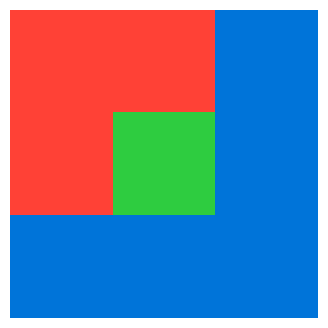

In [5]:
from dsl.utilities.plot import plot_grid 
arr2 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

arr = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 8, 0, 0, 0, 0, 0, 0],
       [0, 0, 9, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

arr = np.array([
              [2, 2, 1],
              [2, 3, 1],
              [1, 1, 1],
              ])

# plot the array as an image
plot_grid(arr)

In [6]:
from dsl.color_select import ColorSelector

colsel = ColorSelector()

popular_color = colsel.mostcolor(arr)
print(f'Most popular color: {popular_color}')
least_popular_color = colsel.leastcolor(arr)
print(f'Least popular color: {least_popular_color}')

second_most_popular_color = colsel.rankcolor(arr, 1)
print(f'Second most popular color: {second_most_popular_color}')

color_of_second_biggest_shape = colsel.rank_largest_shape_color_nodiag(arr, 1)
print(f'Color of second biggest shape: {color_of_second_biggest_shape}')

color_of_second_biggest_shape = colsel.rank_largest_shape_color_diag(arr, 1)
print(f'Color of second biggest shape: {color_of_second_biggest_shape}')

Most popular color: 1
Least popular color: 3
Second most popular color: 2
Color of second biggest shape: 2


DeprecationWarning: This method is deprecated. Use rank_largest_shape_color_nodiag instead.

Selecting by color


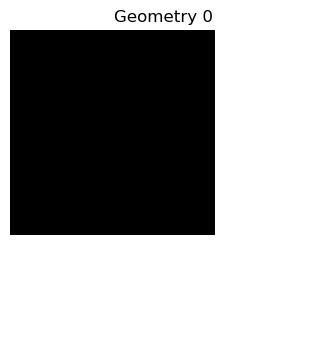

Selecting colored rectange combinations


Warning: Color 0 not found in the grid

In [7]:
from dsl.select import Selector
from dsl.utilities.plot import plot_selection
from skimage.segmentation import find_boundaries

sel = Selector()

print('Selecting by color')
selection = sel.select_color(arr, 1)
plot_selection(selection)

print('Selecting colored rectange combinations')
selection3 = sel.select_connected_shapes(arr, 0)
plot_selection(selection3)

print('Selecting cells adjacent to color')
selection4 = sel.select_connected_shapes(arr, 1)
plot_selection(selection4)

# Test Reinforcement learning loop

In [16]:
from action_space import ARCActionSpace
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d
colsel = ColorSelector
sel = Selector
trn = Transformer

action_space = ARCActionSpace(ColorSelector, Selector, Transformer)


proto_action = np.array([0.5, 0.5, 0.5])
distances, indices, actions = action_space.search_point(proto_action, k=100)
print('Closest actions:', actions[:5])
print(actions.shape)

--------------------------------------------------
Creating the action space


AttributeError: type object 'ColorSelector' has no attribute 'max_embedding'

In [9]:
from enviroment import ARC_Env

env = ARC_Env(training_challenge_dict, action_space=action_space, seed=0)
seed = np.random.seed(1)
random.seed(0)
env.reset()

i = 0
while i<10000:
    i += 1
    action = random.choice(action_space.space)
    state, reward, done, info = env.step(action)
    if i % 1000 == 0:
        print(f'Step: {i}')
        env.reset()

NameError: name 'action_space' is not defined

In [ ]:
import numpy as np

def enlarge(grid, selection, radius):
    """
    Enlarges the selected shape in the grid by a given radius, adding rows and columns of zeros between existing rows and columns.
    
    Args:
        grid (np.ndarray): The original input grid
        selection (np.ndarray): A binary mask indicating the shape (same shape as grid)
        radius (int): Number of cells to expand outward
        
    Returns:
        np.ndarray: A new grid with the enlarged shape
    #TODO: In the DRL environment radius will probably have to be an iterable for low numbers (likely between 1 and 3)
    """
    # Ensure grid and selection are the same shape
    assert grid.shape == selection.shape, "Grid and each selection layer must have the same shape."
    
    rows, cols = grid.shape
    # Create a larger grid with interstitial spaces
    new_rows = rows * 2 - 1
    new_cols = cols * 2 - 1
    
    # Add padding for the expansion
    pad_rows = radius
    pad_cols = radius
    total_rows = new_rows + 2 * pad_rows
    total_cols = new_cols + 2 * pad_cols
    
    # Create padded grid with zeros
    padded_grid = np.zeros((total_rows, total_cols), dtype=grid.dtype)
    padded_selection = np.zeros((total_rows, total_cols), dtype=selection.dtype)
    
    
    # Fill original positions (accounting for padding offset)
    for i in range(rows):
        for j in range(cols):
            if selection[i, j] == 1 and grid[i, j] == 1:
                padded_grid[pad_rows + i*2, pad_cols + j*2] = 1
                padded_selection[pad_rows + i*2, pad_cols + j*2] = 1
    
    # Find all non-zero elements in the grid (enlargement origins)
    enlargement_origins = np.argwhere(padded_grid != 0)

    # Iterate over each origin
    for origin in enlargement_origins:
        row, col = origin

        # Vertical (upwards)
        for r in range(1, radius + 1):
            if row - r >= 0:  # Ensure we don't go out of bounds
                padded_grid[row - r, col] = 1

        # Horizontal (rightwards)
        for c in range(1, radius + 1):
            if col + c < padded_grid.shape[1]:  # Ensure we don't go out of bounds
                padded_grid[row, col + c] = 1

        # Diagonal (right-up)
        for d in range(1, radius + 1):
            if row - d >= 0 and col + d < padded_grid.shape[1]:  # Ensure we don't go out of bounds
                padded_grid[row - d, col + d] = 1

    return padded_grid


# Test the function
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
])

selection = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
])

# Enlarge the selection with a radius of 1 and include diagonal neighbors
result = enlarge(grid, selection, radius=1)

# Print results
print("\nOriginal Grid:")
print(grid)
print("\nEnlarged Grid:")
print(result)



In [ ]:
def count_paths(x, y, last_move=None, consecutive=0, memo={}):
    # Base case: reached destination
    if x == 7 and y == 4:
        return 1
    # Base case: out of bounds
    if x > 7 or y > 4:
        return 0
    # Memoization key
    key = (x, y, last_move, consecutive)
    if key in memo:
        return memo[key]
    
    # Recursive case
    ways = 0
    # Move right if not violating the consecutive constraint
    if last_move != 'R' or consecutive < 2:
        ways += count_paths(x + 1, y, 'R', consecutive + 1 if last_move == 'R' else 1, memo)
    # Move up if not violating the consecutive constraint
    if last_move != 'U' or consecutive < 2:
        ways += count_paths(x, y + 1, 'U', consecutive + 1 if last_move == 'U' else 1, memo)
    
    memo[key] = ways
    return ways

# Compute the number of ways
result = count_paths(0, 0)
result

In [ ]:
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
])

grid = np.expand_dims(grid, axis=0)
print(grid.shape)

def grid_to_tokens(grid):
    """
    Converts a grid to a list of tokens.
    
    Args:
        grid (np.ndarray): The input grid
        
    Returns:
        list: A list of tokens
    """
    tokens = np.zeros(grid.size +2, dtype=np.float32)
    d, nrows, ncols = grid.shape
    tokens[0] = nrows
    tokens[1] = ncols
    tokens[2:] = grid.flatten()
    return tokens

tokens = grid_to_tokens(grid)
print(tokens)


In [ ]:
import numpy as np

def downscale(grid, scale_factor, aggregation_fn=np.max):
    """
    Downscales a grid by a given scale factor using a specified aggregation function.
    
    Args:
        grid (np.ndarray): The input grid to downscale.
        scale_factor (int): The factor by which to reduce the grid's size.
        aggregation_fn (callable): The function to aggregate values in each block (default: np.max).
    
    Returns:
        np.ndarray: The downscaled grid.
    """
    assert grid.shape[0] % scale_factor == 0 and grid.shape[1] % scale_factor == 0, \
        "Grid dimensions must be divisible by scale_factor."
    
    rows, cols = grid.shape
    new_rows = rows // scale_factor
    new_cols = cols // scale_factor

    # Create the downscaled grid
    downscaled_grid = np.zeros((new_rows, new_cols), dtype=grid.dtype)

    # Iterate over blocks and apply aggregation function
    for i in range(new_rows):
        for j in range(new_cols):
            block = grid[
                i * scale_factor:(i + 1) * scale_factor,
                j * scale_factor:(j + 1) * scale_factor
            ]
            downscaled_grid[i, j] = aggregation_fn(block)

    return downscaled_grid

# Test the function
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0]
])

selection = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0]
])

# Enlarge the selection with a radius of 1
result = downscale(grid, 3)

print("\nOriginal Grid:")
print(grid)
print("\nEnlarged Grid:")
print(result.astype(int))  # Convert to int for cleaner printing


Testing

In [ ]:
import numpy as np
from dsl.select import Selector
from dsl.transform import Transformer     
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d, plot_selection, plot_grid


arr = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plot_grid(arr)
sel = Selector(arr.shape)
trn = Transformer()
print('Selecting cells adjacent to color')
selection4 = sel.select_connected_shapes(arr, 1)
plot_selection(selection4)
print('Shift cells')
transformed5 = trn.change_background_color(arr, selection4,7)
plot_grid_3d(transformed5)

In [ ]:
import numpy as np
from dsl.select import Selector
from dsl.transform import Transformer     
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d, plot_selection, plot_grid


arr1 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

arr2 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plot_grid(arr1)
sel1 = Selector(arr1.shape)
sel2 = Selector(arr2.shape)
trn = Transformer()
print('Selecting cells adjacent to color')
selection4 = sel1.select_connected_shapes(arr1, 1)
selection5 = sel2.select_connected_shapes(arr2, 1)
plot_selection(selection4)
print('Vupscale')
transformed5 = trn.vupscale(arr1, selection4, 2)
plot_grid_3d(transformed5)
print('Vectorized Vupscale')
transformed6 = trn.vectorized_vupscale(arr2, selection4, 2)
plot_grid_3d(transformed6)

In [ ]:
import numpy as np
from dsl.select import Selector
from dsl.transform import Transformer     
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d, plot_selection, plot_grid
from dsl.utilities.transformation_utilities import center_of_mass


arr1 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 1, 0, 0, 1, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

arr2 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 1, 0, 0, 1, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

# plot the array as an image
plot_grid(arr1)
sel1 = Selector(arr1.shape)
sel2 = Selector(arr2.shape)
trn = Transformer()
print('Selecting cells adjacent to color')
selection4 = sel1.select_connected_shapes(arr1, 1)
selection5 = sel2.select_connected_shapes(arr2, 1)
plot_selection(selection4)
print('Vupscale')
transformed5 = trn.vupscale(arr1, selection4, 2)
plot_grid_3d(transformed5)
print('Vectorized Vupscale')
transformed6 = trn.vectorized_vupscale(arr2, selection4, 2)
plot_grid_3d(transformed6)



CoM1 = center_of_mass(selection4[0])
CoM2 = center_of_mass(selection4[1])
print(f'Center of mass of shape 0: {CoM1}')
print(f'Center of mass of shape 1: {CoM2}')

In [ ]:
import numpy as np
import time

def maximum_overlap_regions_old(array1, array2):
        """
        Vectorized calculation of maximum overlap between two 2D arrays.
        """
        shape1 = array1.shape
        shape2 = array2.shape
        
        # Calculate possible positions for sliding array2 over array1
        offsets_i = np.arange(-shape2[0] + 1, shape1[0])
        offsets_j = np.arange(-shape2[1] + 1, shape1[1])
        
        # Create grids for all possible offsets
        grid_i, grid_j = np.meshgrid(offsets_i, offsets_j, indexing='ij')
        
        # Calculate the valid overlap regions for each position
        row_start1 = np.maximum(0, grid_i)
        row_end1 = np.minimum(shape1[0], grid_i + shape2[0])
        col_start1 = np.maximum(0, grid_j)
        col_end1 = np.minimum(shape1[1], grid_j + shape2[1])
        
        row_start2 = np.maximum(0, -grid_i)
        row_end2 = row_start2 + (row_end1 - row_start1)
        col_start2 = np.maximum(0, -grid_j)
        col_end2 = col_start2 + (col_end1 - col_start1)
        
        # Calculate overlap scores for all positions
        max_overlap_score = 0
        best_overlap1 = None
        best_overlap2 = None
        
        for idx in np.ndindex(grid_i.shape):
            r1s, r1e = row_start1[idx], row_end1[idx]
            c1s, c1e = col_start1[idx], col_end1[idx]
            r2s, r2e = row_start2[idx], row_end2[idx]
            c2s, c2e = col_start2[idx], col_end2[idx]
            
            region1 = array1[r1s:r1e, c1s:c1e]
            region2 = array2[r2s:r2e, c2s:c2e]
            
            overlap_score = np.sum(region1 == region2)
            
            if overlap_score > max_overlap_score:
                max_overlap_score = overlap_score
                best_overlap1 = (slice(r1s, r1e), slice(c1s, c1e))
                best_overlap2 = (slice(r2s, r2e), slice(c2s, c2e))
        
        return best_overlap1, best_overlap2
# Functions to test
def test_overlap_functions():
    def generate_random_grids(max_size=30):
        size1 = np.random.randint(2, max_size+1, size=2)  # Random size for grid 1
        size2 = np.random.randint(2, max_size+1, size=2)  # Random size for grid 2
        grid1 = np.random.randint(0, 5, size=size1)       # Random grid 1 with values 0-4
        grid2 = np.random.randint(0, 5, size=size2)       # Random grid 2 with values 0-4
        return grid1, grid2

    num_tests = 10
    max_size = 5

    old_times = []
    new_times = []

    for test_idx in range(num_tests):
        grid1, grid2 = generate_random_grids(max_size)

        # Test old function
        start_time = time.time()
        old_result1, old_result2 = maximum_overlap_regions_old(grid1, grid2)
        old_times.append(time.time() - start_time)

        # Test new function
        start_time = time.time()
        new_result1, new_result2 = maximum_overlap_regions(grid1, grid2)
        new_times.append(time.time() - start_time)

        # Verify that the results match
        if old_result1 != new_result1 or old_result2 != new_result2:
            print(f"Mismatch on test {test_idx}:")
            print("Grid1:")
            print(grid1)
            print("Grid2:")
            print(grid2)
            print("Old function results:")
            print(old_result1, old_result2)
            print(grid1[old_result1])
            print(grid2[old_result2])
            print('Overlap:', np.sum(grid1[old_result1] == grid2[old_result2]))
            print('')
            print("New function results:")
            print(new_result1, new_result2)
            print(grid1[new_result1])
            print(grid2[new_result2])
            print('Overlap:', np.sum(grid1[new_result1] == grid2[new_result2]))
            raise AssertionError(f"Mismatch in results on test {test_idx}")

        print(f"Test {test_idx + 1}/{num_tests}: PASSED")

    print(f"\nAverage time for old function: {np.mean(old_times):.6f} seconds")
    print(f"Average time for new function: {np.mean(new_times):.6f} seconds")

# Run the tests
test_overlap_functions()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import inspect
import torch
from joblib import Parallel, delayed

from dsl.utilities.plot import plot_grid, plot_grid_3d, plot_selection, display_challenge
from action_space import ARCActionSpace
from dsl.transform import Transformer
from enviroment import ARC_Env

from cleaner import cleaner

cleaner()